<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/Modele000002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

##Python / Colab
from google.colab import files
from google.colab import drive
import os
from IPython.display import Image as imgIPython
from IPython.display import clear_output,display
import IPython
## Tensorflow keras
try:
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Conv2D,Convolution2D,Activation,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dropout,Reshape,BatchNormalization
from tensorflow.keras.layers import concatenate,Concatenate,Subtract,Multiply,Average,Add
from tensorflow.keras.layers import UpSampling2D, Reshape,Flatten
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tensorflow.keras.losses
## Math libraries
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
##Images
from PIL import Image
import cv2
## Graph
from graphviz import render
from graphviz import Digraph,Graph
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
#Dataset
from __future__ import absolute_import, division, print_function, unicode_literals
import random
import pathlib
import shutil

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TIPE


#Dataset

In [0]:
#@title { display-mode: "form" }

dossier_TIPE = "/content/drive/My Drive/TIPE/"#@param {type:"string"}
localisation_annexe_txt = "list_files.txt"#@param {type:"string"}
part_train = 0.6#@param {type: "number"}
part_validation = 0.3#@param {type: "number"}
part_test = 0.1#@param {type: "number"}

Récupération des images et de celles issues d'entrainements précédents

In [0]:
# dataset_clean = [dossier_TIPE+"Galaxies_resized/"+f for f in os.listdir(dossier_TIPE+"Galaxies_resized/")]
# #Mélange suivant : https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order doc *list https://stackoverflow.com/questions/12555627/python-3-starred-expression-to-unpack-a-list
# lg = len(dataset_clean)
# #Création des indices limites
# parts_lim = [part_train,part_validation,part_test]
# indices_lim = [int(sum(parts_lim[:i+1])*lg) for i in range(len(parts_lim))][:-1]
# #Séparation
# datasets_paths = list(map(lambda x:x.tolist(),np.split(dataset_clean,indices_lim)))
# dossiers = ["Train","Validation","Test"]
# print(os.listdir(dossier_TIPE+"Galaxies_resized/"))
# def move(source,dossier):
#     for i in  range(3):
#         try:
#             dest = source.split("/")+[dossier]
#             dest[-1],dest[-2] = dest[-2],dest[-1]
#             dest = "/".join(dest)
#             os.rename(source,dest)
#             shutil.move(source,dest)
#             os.replace(source,dest)
#         except:
#             pass
# for d_p,d in zip(datasets_paths,dossiers):
#     list(map(lambda x:move(x,d),d_p))

Vérification des datasets

In [13]:
path = dossier_TIPE+"Galaxies_resized/"
dossiers = ["Train","Validation","Test"]
compte = []
for d in dossiers:
    compte.append(len(os.listdir(path+d)))
print([c/sum(compte) for c in compte])

[0.6089108910891089, 0.297029702970297, 0.09405940594059406]


Création des classes de dataset Tensorflow

In [0]:
def get_dataset(nom):
    dataset_path = tf.keras.utils.get_file(
        'Dataset_'+nom,
        dossier_TIPE+"Galaxies_resized/"+nom)
    dataset_path = pathlib.Path(dataset_path)
    #doc de pathlib : https://docs.python.org/3/library/pathlib.html
    list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))


max :  tf.Tensor(1.0, shape=(), dtype=float32)


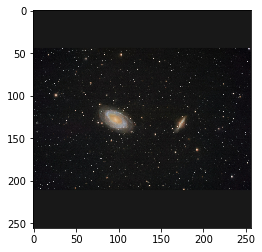

In [374]:
data = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+"Train"+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+"Train")))
a = None
i = 0
for s in data:
    if i ==0:
        a = s
    i+=1
def open(x):
    """Modification par image"""
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    print("max : ",tf.reduce_max(img))
    img = tf.image.resize(img, [256, 256])
    img = tf.clip_by_value(img,0,1)
    img_noise = img
    #Bruit
    bruit_colore = tf.clip_by_value(tf.random.normal(mean=5e-2,stddev=1e-2,shape=tf.shape(img)),0,1)
    #Applique au batch
    img_noise = img+bruit_colore
    # img_noise = tf.image.adjust_contrast(img_noise,0.2)
    img_noise = tf.image.adjust_saturation(img_noise,1.5)
    img_noise = tf.image.adjust_hue(img_noise,0.09)
    img_noise = tf.clip_by_value(img_noise,0,1)
    return img,img_noise

res = data.batch(5)
file_path = next(iter(res))
image,img_noise = open(file_path[0])
plt.imshow(image)



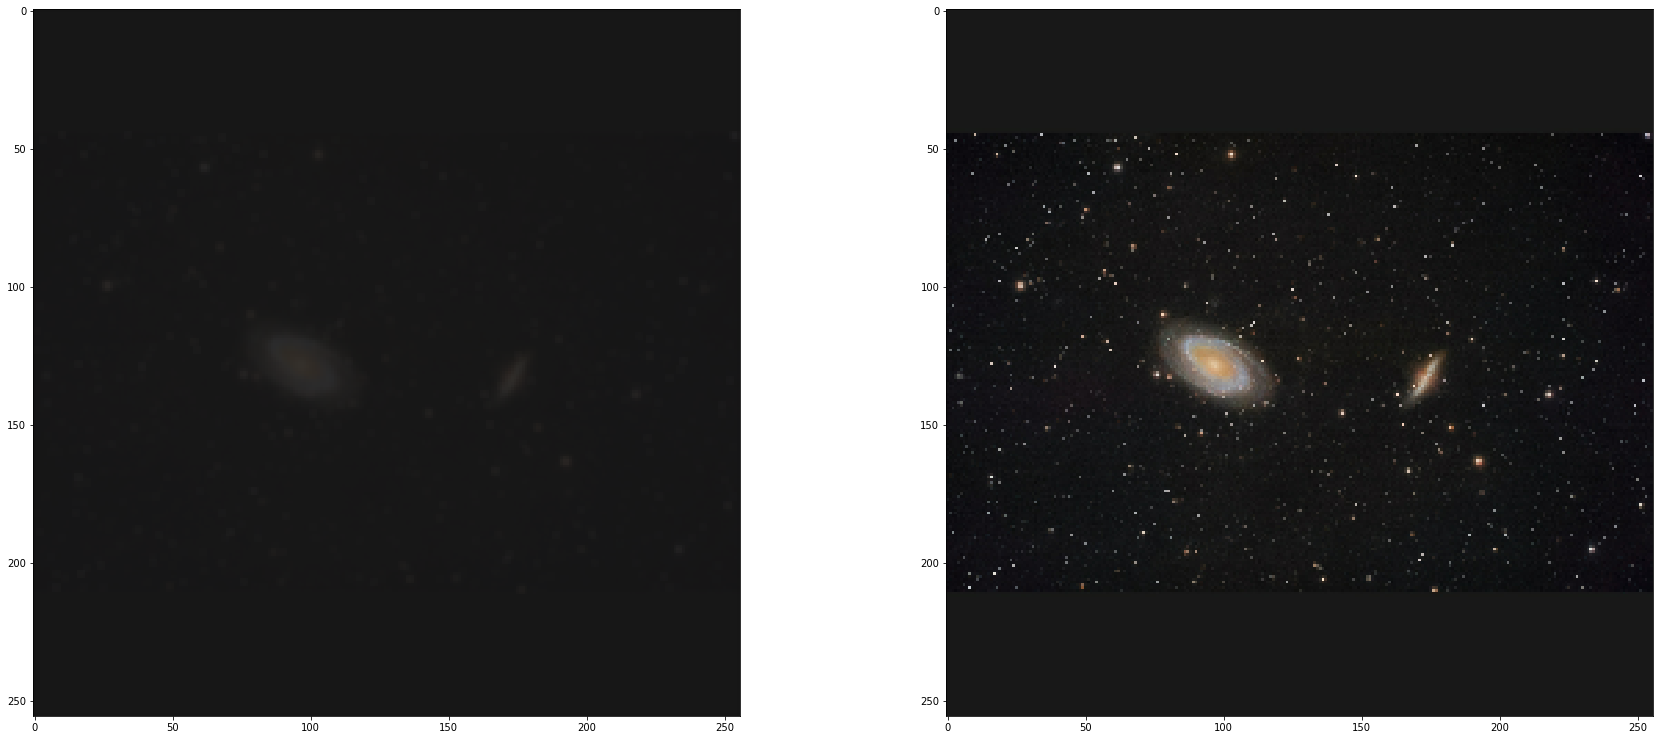

In [376]:
img = image
#Bruit gaussien origine : https://stackoverflow.com/questions/59286171/gaussian-blur-image-in-dataset-pipeline-in-tensorflow
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)


def apply_blur(img):
    img = tf.reshape(img,[1,256,256,3])
    blur = _gaussian_kernel(3, 2, 3, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return tf.reshape(img,[256,256,3])


#Applique au batch
img_noise = img
# img_noise = tf.image.adjust_contrast(img_noise,0.15)
# img_noise = tf.image.adjust_brightness(img_noise,0.2)
img_noise1 = tf.image.adjust_saturation(img_noise,.8)
# img_noise3 = tf.image.adjust_contrast(img_noise,5)# (x-mean)*f+mean --> mean =mean
img_noise2 = apply_blur(img_noise1)
img_noise3 = tf.image.adjust_contrast(img_noise2,0.15)
img_noise4 = tf.image.adjust_brightness(img_noise3,.2)
img_noise = tf.clip_by_value(img_noise4,0,1)


plt.figure(figsize=(30,13))
plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(img_noise3,vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(img,vmin=0, vmax=1)
# plt.subplot(2,4,1)
# plt.imshow(image,vmin=0, vmax=1)
# plt.subplot(2,4,2)
# plt.imshow(img_noise1,vmin=0, vmax=1)
# plt.subplot(2,4,3)
# plt.imshow(img_noise2,vmin=0, vmax=1)
# plt.subplot(2,4,4)
# plt.imshow(img_noise3,vmin=0, vmax=1)
# plt.subplot(2,4,5)
# plt.imshow(img_noise4,vmin=0, vmax=1)

In [0]:
#D'après https://stackoverflow.com/questions/54590363/create-tensorflow-dataset-from-image-local-directory
class ArtificialDataset(tf.data.Dataset):
    def process_path(file_path):
        img_clean = tf.io.read_file(file_path)
        #Calcul des facteurs de voile
        random_in_interval = np.random.rand(self.batch_size,3)*abs(voile_pow_neg_10_val1-voile_pow_neg_10_val2) +min(voile_pow_neg_10_val1,voile_pow_neg_10_val2)
        random_factor = 10**-(random_in_interval)
        # Calcul du bruit
        bruit = np.random.normal(μ_bruit,σ_bruit,size=(self.batch_size,self.taille_img,self.taille_img,3))
        #Applique au batch
        for img in range(self.batch_size):
            if type(batch_bruit[img]) != np.ndarray:
                for rgb_index in range(3):
                    batch_noise[img,:,:,rgb_index] *= random_factor[img,rgb_index]
                    batch_noise[img,:,:,rgb_index] += bruit[img,:,:,rgb_index]
            else:
                batch_noise[img,:,:,:] = batch_bruit[img]

        #Choix de la méthode d'ajustement à l'intervalle
        if typ == 'clip':
            batch_noise = np.clip(batch_noise,0,1)
        else:
            batch_noise = self.normalisation(batch_noise)
        return tf.io.read_file(file_path), label
    @staticmethod
    def list_files(file_pattern, nom, batch_size, shuffle=None, seed=None):
        donnees = os.listdir(dossier_TIPE+"Galaxies_resized/"+cls.nom)
        random.shuffle(donnees)
        self.donnees = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+nom+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+nom))).batch(5)
        return super().list_files(file_pattern, shuffle, seed)
    def _generator(cls):
        
            yield (sample_idx,)
    
    def __new__(cls):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=()
        )
